In [1]:
from pyspark.sql import SparkSession
from operator import add

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.111:7077") \
        .appName("lyrics_mapreduce_test")\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 4)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

#        .config("spark.cores.max", 8)\
# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("INFO")

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from stop_words import get_stop_words
import time

#TEST EXECUTION
a= time.perf_counter()

#Get most frequent words for each song ID
lyrics = spark_session.read\
           .option("header", "true")\
           .csv("hdfs://192.168.2.111:9000/user/ubuntu/lyrics_database.csv")\
            .limit(round(19045332 /2))\
            .cache()
lyrics.count()

#Get genre tags for each song ID
lastfm = spark_session.read\
           .json("hdfs://192.168.2.111:9000/user/ubuntu/lastfm/lastfm_test/*/*/*")\
            .repartition(30)\
            .limit(round(59394 /2))\
            .cache()

#Filter out irrelevant attributes in genre dataset
genre = lastfm.filter(F.size(lastfm["tags"]) > 0 )\
        .select("tags", "track_id")\
        .cache()
genre.count()



#Join both datasets on their ID
paired_songs = lyrics.join(genre, "track_id").cache()
paired_songs.show(4)


#Filter stopwords from the frequent words
stopwords = get_stop_words("english")
#Create new DataFrame that contains one row for each genre tag, the word, and the word count in each song
songs_expanded = paired_songs.filter(paired_songs['word'].isin(stopwords)==False)\
                        .select(paired_songs["word"],\
                                paired_songs["count"],\
                                F.explode(paired_songs["tags"]))\
                        .withColumnRenamed("col","genre")\
                        .cache()
    
songs_expanded.show(3)


#Remove second element in tuple to obtain only genre tag
def remove_similarity(genre_tuple):
    genre, _ = genre_tuple
    return genre

tags_function = F.udf(remove_similarity, StringType())

#Cast count to an integer type and remove second element in genre tuple 
wordcount_genre = songs_expanded.withColumn("genre", tags_function(songs_expanded["genre"]))\
                            .withColumn("wordcount", songs_expanded["count"].cast(IntegerType()))\
                            .drop("count")\
                            .cache()

wordcount_genre.show(2)


# Group elements with common genre and word, and sum their wordcounts
wordcount_genre.groupBy("word", "genre")\
                .agg(F.sum("wordcount"))\
                .sort("sum(wordcount)",ascending=False)\
                .show()

#Group elements by genre and word, to see which pairs are the most frequent
wordcount_genre.groupBy("genre", "word")\
                .count()\
                .sort("count", ascending=False)\
                .show()

runningtime= time.perf_counter() - a

#Remove Dataframes from cache to avoid execution depending on it
lyrics.unpersist()
lastfm.unpersist()
genre.unpersist()
paired_songs.unpersist()
songs_expanded.unpersist()
wordcount_genre.unpersist()

print(runningtime)

+------------------+----+-----+--------------------+
|          track_id|word|count|                tags|
+------------------+----+-----+--------------------+
|TRNQZQT128F14585A6| the|    5|[[comedy, 100], [...|
|TRNQZQT128F14585A6| you|    5|[[comedy, 100], [...|
|TRNQZQT128F14585A6|  to|    7|[[comedy, 100], [...|
|TRNQZQT128F14585A6| and|    9|[[comedy, 100], [...|
+------------------+----+-----+--------------------+
only showing top 4 rows

+----+-----+-------------------+
|word|count|              genre|
+----+-----+-------------------+
|will|    2|      [comedy, 100]|
|will|    2|[Monty Python, 100]|
|like|    1|      [comedy, 100]|
+----+-----+-------------------+
only showing top 3 rows

+----+------------+---------+
|word|       genre|wordcount|
+----+------------+---------+
|will|      comedy|        2|
|will|Monty Python|        2|
+----+------------+---------+
only showing top 2 rows

+-----+-----------+--------------+
| word|      genre|sum(wordcount)|
+-----+-----------+-

In [7]:
spark_context.stop()

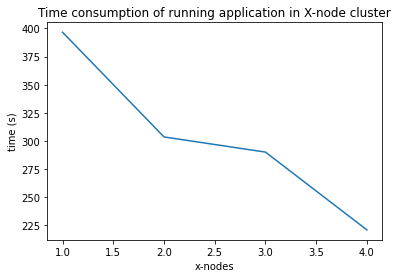

In [21]:
#Output Graph
import numpy as np
from matplotlib import pyplot as plt

listTimeConsumption = [396.58615512899996,303.6207441180013,290.15585375500086,221.03893264900398]
nodes = [1,2,3,4]

plt.title("Time consumption of running application in X-node cluster") 
plt.xlabel("x-nodes") 
plt.ylabel("time (s)") 

plt.plot(nodes,listTimeConsumption) 
plt.show()


In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from stop_words import get_stop_words
import time

#TEST EXECUTION
a= time.perf_counter()

#Get most frequent words for each song ID
lyrics = spark_session.read\
           .option("header", "true")\
           .csv("hdfs://192.168.2.111:9000/user/ubuntu/lyrics_database.csv")\
          .limit(round(19045332 /4))\
            .cache()

#Get genre tags for each song ID
lastfm = spark_session.read\
           .json("hdfs://192.168.2.111:9000/user/ubuntu/lastfm/lastfm_test/*/*/*")\
            .repartition(30)\
            .limit(round(59394 /4))\
            .cache()

#Filter out irrelevant attributes in genre dataset
genre = lastfm.filter(F.size(lastfm["tags"]) > 0 )\
        .select("tags", "track_id")\
        .cache()


#Join both datasets on their ID
paired_songs = lyrics.join(genre, "track_id").cache()
paired_songs.show(4)


#Filter stopwords from the frequent words
stopwords = get_stop_words("english")
#Create new DataFrame that contains one row for each genre tag, the word, and the word count in each song
songs_expanded = paired_songs.filter(paired_songs['word'].isin(stopwords)==False)\
                        .select(paired_songs["word"],\
                                paired_songs["count"],\
                                F.explode(paired_songs["tags"]))\
                        .withColumnRenamed("col","genre")\
                        .cache()
    
songs_expanded.show(3)


#Remove second element in tuple to obtain only genre tag
def remove_similarity(genre_tuple):
    genre, _ = genre_tuple
    return genre

tags_function = F.udf(remove_similarity, StringType())

#Cast count to an integer type and remove second element in genre tuple 
wordcount_genre = songs_expanded.withColumn("genre", tags_function(songs_expanded["genre"]))\
                            .withColumn("wordcount", songs_expanded["count"].cast(IntegerType()))\
                            .drop("count")\
                            .cache()

wordcount_genre.show(2)


# Group elements with common genre and word, and sum their wordcounts
wordcount_genre.groupBy(wordcount_genre["word"], wordcount_genre["wordcount"], wordcount_genre["genre"])\
                .count()\
                .sort("count",ascending=False)\
                .drop("wordcount")\
                .show()

#Group elements by genre and word, to see which pairs are the most frequent
wordcount_genre.groupBy("genre", "word")\
                .count()\
                .sort("count", ascending=False)\
                .show()

runningtime= time.perf_counter() - a

lyrics.unpersist()
lastfm.unpersist()
genre.unpersist()
paired_songs.unpersist()
songs_expanded.unpersist()
wordcount_genre.unpersist()

print(runningtime)

+------------------+----+-----+--------------------+
|          track_id|word|count|                tags|
+------------------+----+-----+--------------------+
|TRNRNOY128F92D4BFE|   i|   10|[[bblues, 100], [...|
|TRNRNOY128F92D4BFE| the|    3|[[bblues, 100], [...|
|TRNRNOY128F92D4BFE| you|    8|[[bblues, 100], [...|
|TRNRNOY128F92D4BFE| and|    8|[[bblues, 100], [...|
+------------------+----+-----+--------------------+
only showing top 4 rows

+----+-----+-----------------+
|word|count|            genre|
+----+-----+-----------------+
|know|    2|    [bblues, 100]|
|know|    2|[4-WAYMUSIC, 100]|
|just|    2|    [bblues, 100]|
+----+-----+-----------------+
only showing top 3 rows

+----+----------+---------+
|word|     genre|wordcount|
+----+----------+---------+
|know|    bblues|        2|
|know|4-WAYMUSIC|        2|
+----+----------+---------+
only showing top 2 rows

+----+-----------+-----+
|word|      genre|count|
+----+-----------+-----+
| see|       rock|   72|
|just|       roc

In [5]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from stop_words import get_stop_words
import time

#TEST EXECUTION
a= time.perf_counter()

#Get most frequent words for each song ID
lyrics = spark_session.read\
           .option("header", "true")\
           .csv("hdfs://192.168.2.111:9000/user/ubuntu/lyrics_database.csv")\
            .cache()

#Get genre tags for each song ID
lastfm = spark_session.read\
           .json("hdfs://192.168.2.111:9000/user/ubuntu/lastfm/lastfm_test/*/*/*")\
            .repartition(30)\
            .cache()

#Filter out irrelevant attributes in genre dataset
genre = lastfm.filter(F.size(lastfm["tags"]) > 0 )\
        .select("tags", "track_id")\
        .cache()


#Join both datasets on their ID
paired_songs = lyrics.join(genre, "track_id").cache()
paired_songs.show(4)


#Filter stopwords from the frequent words
stopwords = get_stop_words("english")
#Create new DataFrame that contains one row for each genre tag, the word, and the word count in each song
songs_expanded = paired_songs.filter(paired_songs['word'].isin(stopwords)==False)\
                        .select(paired_songs["word"],\
                                paired_songs["count"],\
                                F.explode(paired_songs["tags"]))\
                        .withColumnRenamed("col","genre")\
                        .cache()
    
songs_expanded.show(3)


#Remove second element in tuple to obtain only genre tag
def remove_similarity(genre_tuple):
    genre, _ = genre_tuple
    return genre

tags_function = F.udf(remove_similarity, StringType())

#Cast count to an integer type and remove second element in genre tuple 
wordcount_genre = songs_expanded.withColumn("genre", tags_function(songs_expanded["genre"]))\
                            .withColumn("wordcount", songs_expanded["count"].cast(IntegerType()))\
                            .drop("count")\
                            .cache()

wordcount_genre.show(2)


# Group elements with common genre and word, and sum their wordcounts
wordcount_genre.groupBy(wordcount_genre["word"], wordcount_genre["wordcount"], wordcount_genre["genre"])\
                .count()\
                .sort("count",ascending=False)\
                .drop("wordcount")\
                .show()

#Group elements by genre and word, to see which pairs are the most frequent
wordcount_genre.groupBy("genre", "word")\
                .count()\
                .sort("count", ascending=False)\
                .show()

runningtime= time.perf_counter() - a

lyrics.unpersist()
lastfm.unpersist()
genre.unpersist()
paired_songs.unpersist()
songs_expanded.unpersist()
wordcount_genre.unpersist()

print(runningtime)

+------------------+----+-----+--------------------+
|          track_id|word|count|                tags|
+------------------+----+-----+--------------------+
|TRAGRAZ128F4219FB4|   i|   13|[[ska, 100], [ska...|
|TRAGRAZ128F4219FB4| the|    1|[[ska, 100], [ska...|
|TRAGRAZ128F4219FB4| you|    9|[[ska, 100], [ska...|
|TRAGRAZ128F4219FB4|  to|    3|[[ska, 100], [ska...|
+------------------+----+-----+--------------------+
only showing top 4 rows

+----+-----+--------------+
|word|count|         genre|
+----+-----+--------------+
|will|    3|    [ska, 100]|
|will|    3|[ska punk, 70]|
|will|    3|    [rock, 20]|
+----+-----+--------------+
only showing top 3 rows

+----+--------+---------+
|word|   genre|wordcount|
+----+--------+---------+
|will|     ska|        3|
|will|ska punk|        3|
+----+--------+---------+
only showing top 2 rows

+----+-----+-----+
|word|genre|count|
+----+-----+-----+
|just| rock|  941|
|time| rock|  934|
|will| rock|  929|
|like| rock|  905|
|know| rock|  89